In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import math
import matplotlib.pyplot as plt
import torch.nn.init as init
import time

In [2]:
def np_to_torch(arr):
    
    arr = torch.FloatTensor(arr)
    arr = arr.unsqueeze(-1)
    arr = arr.clone().detach().requires_grad_(True)
    
    return arr

def xy_train_data(N_x, x_l, x_r, N_y, y_b, y_t, N_bc, r, xb, yb):
    
    x_train = []
    y_train = []
    
    #Collocation points
    dx = (x_r - x_l)/(N_x - 1)
    dy = (y_t - y_b)/(N_y - 1)
    for i in range(N_x):
        for j in range(N_y):
            x = x_l + i*dx
            y = y_b + j*dy
            
            if( (x-xb)**2 + (y-yb)**2 > r**2):
                x_train.append(x)
                y_train.append(y)
            
    #Boundary points
    for i in range(N_bc):
        x_train.append(xb + r*np.cos(i*2*math.pi/N_bc))
        y_train.append(yb + r*np.sin(i*2*math.pi/N_bc))
    
    x_train = np.asarray(x_train)
    y_train = np.asarray(y_train)
    x_train = np_to_torch(x_train)
    y_train = np_to_torch(y_train)
    
    return x_train, y_train

def initial_temp(x_train, y_train, N_tot, N_bc, T_l, T_r, x_l, y_t, y_b):
    
    T_prev = np.ones(N_tot)*T_r
    x_train = x_train.detach().numpy()
    y_train = y_train.detach().numpy()
    for i in range(-1, -N_bc-1, -1):
        T_prev[i] = T_l
            
    T_prev = np_to_torch(T_prev)
    
    return T_prev
            
def xavier_init(m):
    if isinstance(m, nn.Linear):
        init.xavier_normal_(m.weight)
        if m.bias is not None:
            init.constant_(m.bias, 0.05)
    
class ANN(nn.Module):
    def __init__(self, layer_size):
        super(ANN, self).__init__()
        
        # Fully conected model-1
        modules_1 = []
        for i in range(len(layer_size) - 1):
            modules_1.append(nn.Linear(layer_size[i], layer_size[i+1]))  
            if i < ( len(layer_size) - 2 ):
                modules_1.append(nn.Tanh())
        
        modules_1.append(nn.Softplus(beta=3))
        self.fc_1 = nn.Sequential(*modules_1)
        for layer in self.fc_1.modules():
            if isinstance(layer, nn.Linear):
                 layer.weight.data.normal_(mean=0, std=0.4)
#         self.fc_1.apply(xavier_init)
        
    def forward(self, x_train, y_train):
        
        T = self.fc_1( torch.cat((x_train, y_train),1) )
        dTdx = torch.autograd.grad(T, x_train, grad_outputs=torch.ones_like(T), create_graph=True)[0]
        d2Tdx2 = torch.autograd.grad(dTdx, x_train, grad_outputs=torch.ones_like(dTdx), create_graph=True)[0]
        dTdy = torch.autograd.grad(T, y_train, grad_outputs=torch.ones_like(T), create_graph=True)[0]
        d2Tdy2 = torch.autograd.grad(dTdy, y_train, grad_outputs=torch.ones_like(dTdy), create_graph=True)[0]
        
        return T, dTdx, dTdy, d2Tdx2, d2Tdy2
    
def get_loss(x_train, y_train, k1, del_t, T_l, w1, w2, w3, w4, 
             T_prev, mat_1, mat_2, mat_3, N_tot, N_1, N_2, N_3, mae, null):

    T, dTdx, dTdy, d2Tdx2, d2Tdy2 = model(x_train, y_train)
    
#     eq1 = w1*torch.sum( torch.square( T - T_prev - del_t*k1*(d2Tdx2 + d2Tdy2) ) ) /(N_tot)
#     bc1 = w2*torch.sum( torch.square( torch.mul(mat_1, T - T_l ) ) )/(N_1)
#     bc2 = w3*(torch.sum( torch.square( torch.mul( mat_2, T ) ) ) )/(N_2)
#     bc3 = w4*(torch.sum( torch.square( torch.mul( mat_3, T ) ) ) )/(N_3)
    
    eq1 = w1*mae( T - T_prev - del_t*k1*(d2Tdx2 + d2Tdy2), null )
    bc1 = w2*mae( torch.mul(mat_1, T - T_l ), null  )*N_tot/200
    bc2 = w3*mae( torch.mul(mat_2, T ), null )*N_tot/80
    bc3 = w4*mae( torch.mul(mat_3, T ), null )*N_tot/80
    
    loss = eq1 +  bc1 + bc2 + bc3 
    
    return loss, eq1, bc1, bc2, bc3

def print_loss(epoch, loss, eq1, bc1, bc2, bc3):
    print('epoch = ',epoch)
    print('loss = ',loss)
    print('eq1_loss = ',eq1)
    print('bc1_loss = ',bc1)
    print('bc2_loss = ',bc2)
    print('bc3_loss = ',bc3)

In [3]:
N_x = 40
N_y = 40
N_t = 2
N_bc = 200

x_l = 0
y_b = 0
x_r = 0.1
y_t = 0.1
xb = 0.05
yb = 0.05
r = 0.025

T_r = 0
T_l = 0.5

t_i = 0
t_f = 0.2

del_t = 0.001

# Neural network params
layer_size = [2, 4, 4, 1]

# material params
k1 = 0.05

# Training data and initial data
model = ANN(layer_size)
print(model)
total_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Total trainable parameters in the model:", total_trainable_params)

# # Setup Loss function and Optimiser
epochs =140001
lr1 = 8.5e-5
lr2 = 1e-4
optimiser1 = torch.optim.Adam(model.parameters(), lr=lr1)
optimiser2 = torch.optim.Adam(model.parameters(), lr=lr2)

ANN(
  (fc_1): Sequential(
    (0): Linear(in_features=2, out_features=4, bias=True)
    (1): Tanh()
    (2): Linear(in_features=4, out_features=4, bias=True)
    (3): Tanh()
    (4): Linear(in_features=4, out_features=1, bias=True)
    (5): Softplus(beta=3, threshold=20)
  )
)
Total trainable parameters in the model: 37


In [4]:
# Lists for storing
loss_store = []
T_store_pred = []
t_store = []
model.train()  

# Initial conditions
x_train, y_train = xy_train_data(N_x, x_l, x_r, N_y, y_b, y_t, N_bc, r, xb, yb)
N_tot = x_train.shape[0]
T_prev = initial_temp(x_train, y_train, N_tot, N_bc, T_l, T_r, x_l, y_t, y_b)
t_test = 0
T_store_pred.append(T_prev.detach().numpy())

# Loss function weights
w1 = 1
w2 = 1
w3 = 1
w4 = 1

# Loss function
mae = nn.HuberLoss(reduction='mean', delta=0.)
null = torch.zeros(N_tot, 1)

mat_1 = np.ones(N_tot)
N_1 = N_bc
for i in range(N_tot - N_1):
    mat_1[i] = 0
mat_1 = np_to_torch(mat_1)
mat_2 = torch.where(x_train == x_l,1,0) + torch.where(x_train == x_r,1,0)
N_2 = torch.sum( mat_2 )
mat_3 = torch.where(y_train == y_t,1,0) + torch.where(y_train == y_b,1,0)
N_3 = torch.sum( mat_3 )

print(N_1, N_2, N_3)
for i in range(N_t):

    t_test = t_test + del_t
    t_store.append(t_test)
    print("t = ", t_test)
    print(" ")
    
    if(i>0):
        epochs = 2001

    for epoch in range(epochs):        
        #Backpropogation and optimisation
        loss, eq1, bc1, bc2, bc3 = get_loss(x_train, y_train, k1, del_t, T_l, w1, w2, w3, w4, T_prev, 
                                            mat_1, mat_2, mat_3, N_tot, N_1, N_2, N_3, mae, null)
        loss_store.append(loss.detach().numpy())
        if epoch<30000:
            optimiser1.zero_grad()
            loss.backward()
            optimiser1.step()
        else:
            optimiser2.zero_grad()
            loss.backward()
            optimiser2.step()
        
        if epoch%2000==0:
            print_loss(epoch, loss, eq1, bc1, bc2, bc3)
            print("")
    
    # Store the results after each time step
    T_prev, dTdx, dTdy, d2Tdx2, d2Tdy2 = model(x_train, y_train)
    T_store_pred.append(T_prev.detach().numpy())

    T_prev = torch.FloatTensor(T_store_pred[-1]).clone().detach().requires_grad_(False)

200 tensor(80) tensor(80)
t =  0.001
 
epoch =  0
loss =  tensor(0.1099, grad_fn=<AddBackward0>)
eq1_loss =  tensor(0.0145, grad_fn=<MulBackward0>)
bc1_loss =  tensor(0.0895, grad_fn=<DivBackward0>)
bc2_loss =  tensor(0.0030, grad_fn=<DivBackward0>)
bc3_loss =  tensor(0.0030, grad_fn=<DivBackward0>)

epoch =  2000
loss =  tensor(0.1015, grad_fn=<AddBackward0>)
eq1_loss =  tensor(0.0173, grad_fn=<MulBackward0>)
bc1_loss =  tensor(0.0642, grad_fn=<DivBackward0>)
bc2_loss =  tensor(0.0100, grad_fn=<DivBackward0>)
bc3_loss =  tensor(0.0100, grad_fn=<DivBackward0>)

epoch =  4000
loss =  tensor(0.1015, grad_fn=<AddBackward0>)
eq1_loss =  tensor(0.0173, grad_fn=<MulBackward0>)
bc1_loss =  tensor(0.0642, grad_fn=<DivBackward0>)
bc2_loss =  tensor(0.0100, grad_fn=<DivBackward0>)
bc3_loss =  tensor(0.0100, grad_fn=<DivBackward0>)

epoch =  6000
loss =  tensor(0.1015, grad_fn=<AddBackward0>)
eq1_loss =  tensor(0.0173, grad_fn=<MulBackward0>)
bc1_loss =  tensor(0.0641, grad_fn=<DivBackward0>)
bc2

KeyboardInterrupt: 

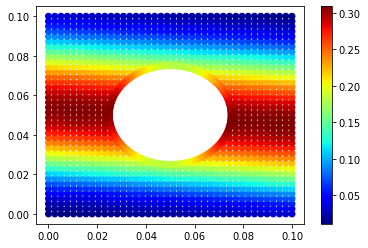

In [5]:
T_prev, dTdx, dTdy, d2Tdx2, d2Tdy2 = model(x_train, y_train)
T_store_pred.append(T_prev.detach().numpy())
k = 1
X = x_train.detach().numpy()
Y = y_train.detach().numpy()
T = T_store_pred[k]
sc = plt.scatter(X, Y, c=T, cmap=plt.cm.jet)
plt.colorbar(sc)
# plt.scatter( X,Y,T, cmap =plt.cm.jet, levels = 100)

In [ ]:
N_tot

In [ ]:
plt.plot(loss_store[:79000])

In [ ]:
mae = nn.L1Loss()
null = torch.zeros(10, 1)